# Intro

In this notebook we are gonna attempt to train a HMM (Hiden Markov Model). The goal is make an HMM that will recognize Named Entities.

For this notebook we are going to use the HMM tagger from NLTK which has a trainer and implements the Viterbi Algorithm to generate predictions.

## 1. HMM Theory
Before starting let's birefly review a little bit about HMM:   
( Summary based on this lecture:  https://www.cs.bgu.ac.il/~elhadad/nlp11/prob/postagging.pdf )

One common use for HMM is to solve the Part of Speech problem defined as:   
**Given a word sequence $w_1, w_2, w3 .. w_m$  determine the corresponding POS tag sequence  $t_1, t_2, t_3 .. t_m$**

### Problem statement from a probabilistic point of view

Find the most probable sequence of tags for a given sequence of words: 

$$argmax_{t_1..t_m}P(t_1..t_m | w_1 .. w_m)$$  
Applying Bayes Theorem we can re-define:   
$$= argmax_{t_1..t_m}\frac{P(t_1..t_m)P(w_1..w_m|t_1..t_m)}{P(w_1..w_m)}$$   
$$= argmax_{t_1..t_m}{P(t_1..t_m)P(w_1..w_m|t_1..t_m)}$$



The resulting expression can be read as: Find the sequence of tags t1..tm that is more likely to appear in a text and produce the sequence of words w1..wm. 

### Independence assumptions
There are some assumptions made that constrain the problem:
- Contextual Model: Tags are dependent only on the precedent tags.
- Lexical Model: Words are dependent only on their own part-of-speech tag.

Thus the problem expression changes to:
$$= argmax_{t_1..t_m} \prod_{i=1}^{m}P(t_i|t_{i-1})P(w_i|t_i)$$


### How does a HMM help in solving the problem?
Well the hmm fits this problem perfectly.   
**A HMM consists of 5 parts**
- a finite set of states  *States = { $s_1 ... s_k$ }*  these are the tags.
- a finite set of signal alphabet *Signals = { $o_1 .. o_m$ }* these are the possible words.
- Initial probabilities *$P(s)$ for every s in States*. i.e. the probability of starting on s.
- Transition probabilities *$P( s_i | s_j )$*
- Emission probabilities   *$P( o | s )$*

**The state transitions are assumed dependent only on the state   
(just as the Contextual Model of POS)**

$$P(s_1..s_n) = \prod_{i=1}^n P(s_i | s_{i-1} ) )$$ 

** Signal emmisions are assumed to be dependent only on the current states   
(just as Lexical Model of the POS)**

$$ P( s_1..s_n, o_1, o_n ) = \prod_{i=1}^n P(s_i | s_{i-1} ) P(o_i | s_i )$$


### Parameter Estimation
So, we got a model that fits the description of the problem, now what?   
Answer: Well, let's see what we have according to the problem statement:   
**What we have:**
- A sequence of words which we can be considered as signal emissions.
- A sequence of POS tags which we can be considered as the corresponding states (only for supervised learning).
- The signal alphabet which is the set of unique words.
- The states which is the set of unique POS tags (only for supervised learning).

**What we don't have and is missing to complete the model:**
- The Initial probabilities
- The Transitions probabilities
- The Emission probabilities

There are two approaches to obtain these probabilities:
- **Supervised Learning:** Using frequency counts from a tagged corpus in order to use a MLE estimator(Maximum Likelihood Estimation)
- **Unsupervised Learning:** Use an expectation-maximization algorithm from an untagged corpus.

For this notebook we're gonna focus on the supervised learning using MLE.

#### Maximum Likelihood Estimation

This is a fairly simple task to do:

**Initial and Transition probabilities**  
$$\hat{P}(s_i | s_{i-1} ) = \frac{Count(s_{i-1}, s_i)}{Count(s_{i-1})} $$   
**Emission probabilities**    
$$\hat{P}(o | s ) = \frac{Count(o, s)}{Count(s)} $$

### Tagging

Great! So now we have all the components of the Hidden Markov Model. Are we done? No.    
Let's remember the initial task:
> **Given a word sequence $w_1, w_2, w_3 .. w_m $ determine the corresponding POS tag sequence  $t_1, t_2, t_3 .. t_m$**    
$$argmax_(t_1..t_m) \prod_{i=1}^m P(t_i) P(w_i|t_i) $$

We need to find the tags (aka the states) that maximize the expression! 

A common algorithm to solve the maximization problem in HMM is called the Viterbi Algorithm. Given a sequence of signals, the Viterbi algorithm finds the optimal path in a HMM (i.e. the path that that maximizes the Probability of producing the signal sequence). The Viterbi algorithm does this by applying dynamic programming techniques instead of analyzing every possible path.

In the inside the Viterbi algorithm uses a trellis with nodes that represent the possible states at each step. Using the trellis the algorithm then proceeds to calculate the probability of being in each state at each step. At the same time the algorithm saves into a back-pointer the edge with the maximum probability of transitioning from one step-state to another step-state. After finishing the Viterbi algorithm just follows the maximum back-pointers path from the end to the start node, thus giving us the states that maximize the probability of producing the signal sequence.

More details on the Viterbi algorithm can be found here: 
http://web.mit.edu/6.02/www/f2010/handouts/lectures/L9.pdf

# 2. Hands-on: Clone the NLTK POS tagging demo
In order to understand how to use the nltk hmm first we're gonna clone the nltk Part-of-Speech (POS) tagging demo found in 
http://www.nltk.org/_modules/nltk/tag/hmm.html#demo_pos

The first thing the demo does is call the function *load_pos( )*. That function basically gets and preprocess the data.

So unwrapping the function, first we are going to import the brown corpus and limit it to a number of sentences.

In [176]:
# general purpose libraries
import pandas as pd
import matplotlib.pyplot as plt

#import the brown corpuz
from nltk.corpus import brown

num_sentences = 10000

#using simplified tagset instead of "cleaning" the tags
sentences = brown.tagged_sents(categories='news', tagset='universal')[:num_sentences]  #

/Users/alextabora/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Then, we are going to normalize the words and generate a vocabulary set and a tag set

In [44]:
tag_set = set()
vocab_set = set()
norm_sentences = []

for sent in sentences:
    for idx, word in enumerate(sent):
        #normalize the word
        norm_word = word[0].lower()  
        #add to sets
        vocab_set.add(norm_word)
        tag_set.add(word[1])
        #modify the sentence
        sent[idx] = (norm_word, word[1])
    #add sentence to new list
    norm_sentences += [sent]
    
    
print "tag set length: %i" %len(tag_set)
print "vocabulary set length: %i" %len(vocab_set)
print "sentences length: %i" %len(norm_sentences)

tag set length: 12
vocabulary set length: 13112
sentences length: 4623


**Let's take a sneak peek to the tag set and the vocabulary sets:**

In [41]:
print "Tag Set:"
print tag_set
print 
print "Vocabulary Set (first 10):"
print list(vocab_set)[:10]

Tag Set:
set([u'ADV', u'NOUN', u'ADP', u'PRON', u'DET', u'.', u'PRT', u'VERB', u'X', u'NUM', u'CONJ', u'ADJ'])

Vocabulary Set (first 10):
[u'sunbonnet', u'yellow', u'narcotic', u'four', u'woods', u'boogie', u'railing', u'francesca', u'aggression', u'marching']


Everything seems in order, the tag set values are the POS tags which we wish to predict and the vocabulary set has the  unique words but in lower case.

### Training the HMM tagger

Ok, so to train the model we need to create an instance of a HMM Trainer. The trainer contains functions that generate the model either by **Supervised Learning using MLE (Maximum Likelihood Estimation)** or **Unsupervised Learning using Baum-Welch Algorithm**.  

The init function for HMM trainer has the following inputs:
- **states:** these are the tags 
- **symbols:** this is the word vocabulary 

We are going to use the *train_supervised()* method in order to train the model (aka estimate the HMM probabilities) using the MLE algorithm. This is just as we discussed in the theoretical summary :) 

Finally we will test the model accuracy with the *test()* method. Notice that for this simple example only 10 sentences were used as a testing dataset.

In [45]:
from nltk.tag import HiddenMarkovModelTrainer
trainer = HiddenMarkovModelTrainer(states=tag_set, symbols=vocab_set)

#training the model using the default MLE
hmm = trainer.train_supervised(norm_sentences[10:])
#testing the model
hmm.test(norm_sentences[:10], verbose=False)

accuracy over 284 tokens: 53.52


As we can see the accuracy is low. To get a better score we can use a smoothed probability estimator.

To smooth the MLE estimation we are gonna override the estimator using a Lidstone estimator (additive smoothing). 
https://en.wikipedia.org/wiki/Additive_smoothing

This estimator basically assumes that there are no event probability = 0 by adding a value to the nominator.

$$ O_i = \frac{x_i + gamma}{N+ d*gamma}$$ where $0 <= gamma <=1$ and $i$ in $1..d$ (d is the number of bins)

The smoothed probability will be in between the empirical estimate $\frac{count(x)}{N}$ and the uniform probability $\frac{1}{d}$. 



In [94]:
from nltk.probability import LidstoneProbDist
#training with another estimator
hmm = trainer.train_supervised(
    norm_sentences[10:],
    estimator= lambda fd, bins: LidstoneProbDist(fd, 0.1, bins)
)
#testing the model
hmm.test(norm_sentences[:10], verbose=False)

accuracy over 284 tokens: 93.66


Now this is quite of an improvement for the model.

We have now successfully cloned the demo. It is time to do a challenge by ourselves.

# 3. Challenge

The challenge is to use the hmm tagger to recognize Named Entities (NE).

For this challenge we are going to use the spanish set of the conll2002 corpus. (At this moment it was the only NE tagged corpus in I found in NLTK )

The nice thing about this corpus is that it has already splitted a train and test datasets.


In [167]:
from nltk.corpus import conll2002
train_sents = list(conll2002.iob_sents('esp.train'))
test_sents = list(conll2002.iob_sents('esp.testb'))
print "number of train: %i" %len(train_sents)
print "number of test: %i" %len(test_sents)

number of train: 8323
number of test: 1517


Let's take a sneak peek of how the sentences look 

In [160]:
train_sents[0]

[(u'Melbourne', u'NP', u'B-LOC'),
 (u'(', u'Fpa', u'O'),
 (u'Australia', u'NP', u'B-LOC'),
 (u')', u'Fpt', u'O'),
 (u',', u'Fc', u'O'),
 (u'25', u'Z', u'O'),
 (u'may', u'NC', u'O'),
 (u'(', u'Fpa', u'O'),
 (u'EFE', u'NC', u'B-ORG'),
 (u')', u'Fpt', u'O'),
 (u'.', u'Fp', u'O')]

As we can observe each word has 3 fields:
- The word
- The Part-of-Speech Tag
- The IOB tag with the NE type

### Preprocessing

So let's recall what we need: 
- The symbols
- The states  
- A labeled sequence. 

In this case the symbols are going to be a tuple of two features:  ( Word , POS tag )   
*Note: we are using only two features for this simple challenge you can experiment adding more features... I'll certainly will do in another notebook ;) *

In [168]:
# this function preprocesses the array of sentences and return the symbols and states
def preprocess_conll(sents):
    symbols = set()
    states = set()
    
    for sent in sents:
        for idx, word in enumerate(sent):
            #normalize the word
            norm_word = word[0].lower()  
            #add to sets
            symbols.add( (norm_word, word[1]) ) #in this case the symbol is a tuple of features
            states.add(word[2])
            
            #modify the sentence
            sent[idx] = ( (norm_word, word[1] ), word[2])
    
    return symbols, states

In [169]:
#train set
symbols, states =  preprocess_conll(train_sents)
#test set
preprocess_conll(test_sents)

print "number of symbols: %i" %len(symbols)
print "number of states: %i" %len(states)

number of symbols: 26726
number of states: 9


Just a sneak peek to the data to be sure everything is ok

In [174]:
print "-- states -- "
print states
print
print "-- symbols (first 10) -- "
print sorted(list(symbols))[:10]

-- states -- 
set([u'I-LOC', u'B-ORG', u'I-PER', u'O', u'I-MISC', u'B-MISC', u'I-ORG', u'B-LOC', u'B-PER'])

-- symbols (first 10) -- 
[(u'!', u'Fat'), (u'"', u'Fe'), (u'"bike-\xe1rea"', u'NC'), (u'"ch\xe9"', u'AQ'), (u'"macho"', u'AQ'), (u'"sharia"', u'NC'), (u'%', u'Ft'), (u'%var', u'AQ'), (u"'", u'Fz'), (u"'18", u'Z')]


## Train the HMM 

Just like before let's repeat the code to train a Hidden Markov Model

In [147]:
print "- Creating Trainer"
NE_trainer = HiddenMarkovModelTrainer(states= NE_tag_set, symbols= NE_vocab_set)

#training with another estimator
print "- Training"
NE_hmm = NE_trainer.train_supervised(
    train_sents,
    estimator= lambda fd, bins: LidstoneProbDist(fd, 0.1, bins)
)

print "- Testing"
#testing the model limited to 100 because of performance issues
NE_hmm.test(test_sents[:100], verbose=False)

- Creating Trainer
- Training
- Testing
accuracy over 3711 tokens: 93.56


### Deceiving scores....
So by the looks everything is doing great with the **93.56% of accuracy!**. However the truth is, that we cannot just go with the accuracy score. We should look deeper into the data and the scores.

Let's check if the classes are unbalanced.. ( I always get this bad feeling about overly optimistic scores )

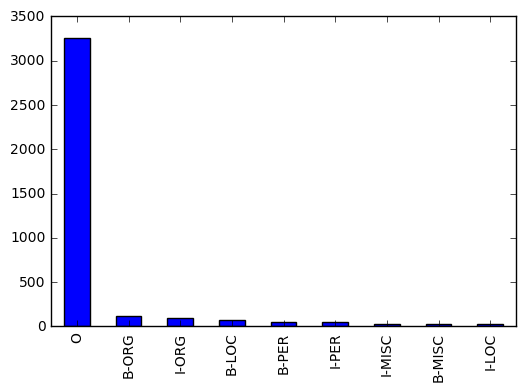

In [199]:
iob_tags = []
for sent in test_sents[:100]:    
    iob_tags += [ str(w[1]) for w in sent]
    
iob_tags = pd.Series(iob_tags)
iob_tags.value_counts().plot('bar')
plt.show()

Aha! As we can see in the graph, the classes are really unbalanced, specially in the 'O' class. In this cases is better to use other scoring methods like precision, recall and f-score.  

## Other scoring methods...

Fortunately sklearn has a function that called classification_report that can shows us what's really happening. 

Below we're gonna use the tag() method from HMM to get the predictions and compare them with the true labels.

In [200]:
from sklearn.metrics import classification_report

print "- Tagging (Predicting)"
words = []
true_labels = []
pred_labels = []
for sent in test_sents[:100]:
    words += [w[0] for w in sent]
    true_labels += [w[1] for w in sent]
    sent_preds = NE_hmm.tag([w[0] for w in sent])
    pred_labels += [w[1] for w in sent_preds]
print 
print classification_report(true_labels, pred_labels)

- Tagging (Predicting)

             precision    recall  f1-score   support

      B-LOC       0.65      0.55      0.59        73
     B-MISC       0.26      0.22      0.24        23
      B-ORG       0.84      0.72      0.77       116
      B-PER       0.76      0.64      0.69        55
      I-LOC       0.80      0.55      0.65        22
     I-MISC       0.22      0.33      0.27        24
      I-ORG       0.64      0.69      0.66        91
      I-PER       0.75      0.88      0.81        49
          O       0.97      0.98      0.97      3258

avg / total       0.94      0.94      0.94      3711



As we can observe, on many classes the f1-score is low with values as low as 0.24. What's happening with our accuracy is that the class label 'O' has many positive samples (3,258) and this is affecting the overall score.

If we ignore that class label, which is not the focus of what we are trying to classify the average results change drastically:

In [201]:
print classification_report(true_labels, pred_labels, labels=sorted(list(NE_tag_set))[:-1])

             precision    recall  f1-score   support

      B-LOC       0.65      0.55      0.59        73
     B-MISC       0.26      0.22      0.24        23
      B-ORG       0.84      0.72      0.77       116
      B-PER       0.76      0.64      0.69        55
      I-LOC       0.80      0.55      0.65        22
     I-MISC       0.22      0.33      0.27        24
      I-ORG       0.64      0.69      0.66        91
      I-PER       0.75      0.88      0.81        49

avg / total       0.68      0.64      0.66       453



a f1-score of .66 is not very good, but for this simple challenge it seems ok. Probably adding more relevant features will make the score go higher (e.g. Capitalized words, N-grams, gazetteer, trigger words etc... ).

## Entity based scoring
So far, the score has been based on the IOB tags for entities, but the real goal of NE tagging is to be able to recognize the entities. Therefore, we should score on how many entities did the model find. 

One common approach to score on an entity basis is to consider only complete entities as correct and partial recognized entities as incorrect. Having said that, we must keep in mind that a mistake of a partial entity will cause a double penalty since it will be accounted as a false positive and a false negative which seems fine to many academic literature.

In the code below, the entities are extracted using the IOB tags (label and pred) and then it is measured wether the model recognized correctly an entity.

In [202]:
#function that extracts the entities using the IOB tags
def get_entities(df, column):
    data = []
    for idx, row in df.iterrows():
        if row[column][0] == "B":
            data.append([idx, row.word[0]])
        elif row[column][0] == "I":
            data[-1][1] += " " + row.word[0]
    return data
    

# Function that extracts entities using the labels and predictions, 
# then compares both list of entities and counts the correct and incorrect predictions, and the missed predictions.
def score_entities(words, true_labels, pred_labels):
    
    # extract the entities
    df = pd.DataFrame({
        "word": words,
        "label":true_labels,
        "pred": pred_labels
    })
    true_entities = get_entities(df, "label")
    pred_entities = get_entities(df, "pred")
    
    
    #count the correct and incorrect predictions, nd the missed predictions.
    tp = 0
    fp = 0
    fn = 0
    
    #look if the predicted entity is in the gold standard.
    for entity in pred_entities:
        if entity in true_entities:
            tp += 1
        else:
            fp += 1
    #look for any missed prediction
    for entity in true_entities:
        if entity not in pred_entities:
            fn += 1
            
    #calculate the scores and print them
    precision = tp * 1.0 / (tp+fp)
    recall = tp * 1.0 / (tp+fn)
    f_score = 2.0 * precision * recall / (precision + recall)
    support = len(true_entities)
    
    print "--- Entity Based Report ---"
    print "precision: %0.4f" %precision
    print "recall: %0.4f" %recall
    print "f_score: %0.4f" %f_score
    print "support: %0.4f" %support
    
    
score_entities(words, true_labels, pred_labels)

--- Entity Based Report ---
precision: 0.7522
recall: 0.6367
f_score: 0.6897
support: 267.0000


### Results
As we can observe the model correctly identified ~64% of the Named Entities using only 2 features (which personally I find it not bad at all). The final f-score is of ~69% which probably can be improved by adding better features.

# Conclusion

In this notebook we succesfully trained a HMM classifier using the NLTK library and with it we were able to use it for Named Entity Recognition. 

We've also learned that its better to score the results using more robust scoring methods such as precision, recall and f1. 

Finally, we scored the HMM results on identifying Named Entities instead of just the tags.